In [ ]:
import os
import glob
import math
import random
import numpy as np
import pandas as pd

# loading image
import PIL

# model with Pytorch architecture
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torchvision.transforms.functional as F

# visualization
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

In [ ]:
from google.colab import drive
drive.mount("content")

Mounted at content


# References:
https://medium.com/@mhamdaan/multi-class-semantic-segmentation-with-u-net-pytorch-ee81a66bba89

# Relabeling Dataset:

# Fix seed

In [ ]:
def same_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

[ 0  1  2  3  4  5  6  7  8 10 11 13 16]


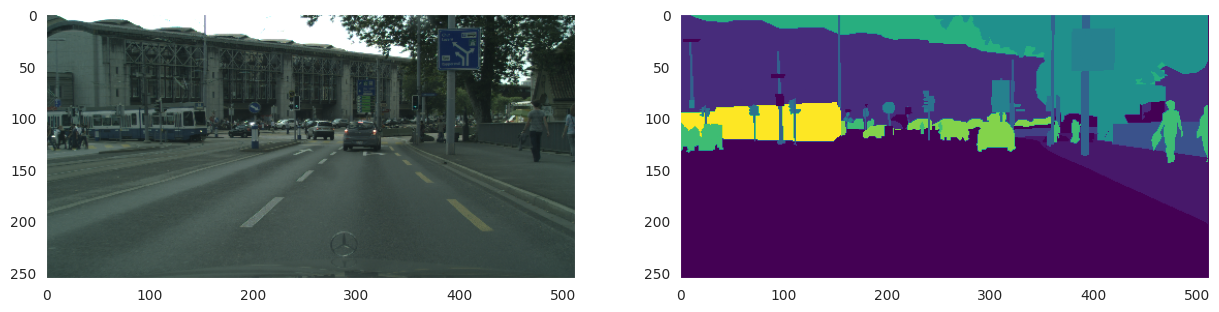

In [ ]:
class CitySpaceDataset(Dataset):
    def __init__(self, split, tsfm=None, label_tsfm=None, n=None):
        super().__init__()
        self.tsfm = None
        self.label_tsfm = None
        self.root_dir = "/content/content/MyDrive/MyAIProjects"
        self.dataset_name= "cityscapes"
        self.img_dir = "leftImg8bit"
        self.label_dir = "gtFine"

        if tsfm:
            self.tsfm = tsfm

        if label_tsfm:
            self.label_tsfm = label_tsfm

        self.img_list = list(glob.glob(os.path.join(self.root_dir, self.dataset_name, self.img_dir, split, "*", "*leftImg8bit.png")))
        self.label_list = [path.replace("leftImg8bit.png","gtFine_labelTrainIds.png").replace(self.img_dir, self.label_dir) for path in self.img_list]
        if n:
            self.img_list = self.img_list[:n]
            self.label_list = self.label_list[:n]

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        # get each image and label with PIL library
        img = PIL.Image.open(self.img_list[idx])
        label = PIL.Image.open(self.label_list[idx])

        if self.tsfm:
            img = tsfm(img)

        if self.label_tsfm:
            label = label_tsfm(label)
        return img, label

tsfm = transforms.Compose([
    # must have interpolation parameter
    transforms.Resize(256, interpolation=F.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

label_tsfm = transforms.Compose(
    [# must have interpolation parameter
    transforms.Resize(256, interpolation=F.InterpolationMode.NEAREST),
    # will keep the output value to 0 - 255
    transforms.PILToTensor()]
)

obj = CitySpaceDataset(split="train", tsfm=tsfm, label_tsfm=label_tsfm)
img, label = obj.__getitem__(1)

# for visualizing the result with matplotlib
ToImageTsfm = transforms.ToPILImage()
img, label =  ToImageTsfm(img), ToImageTsfm(label)
label = np.array(label)
label[label==255] = 0
print(np.unique(label))
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(img)
ax[1].imshow(label, cmap="viridis")

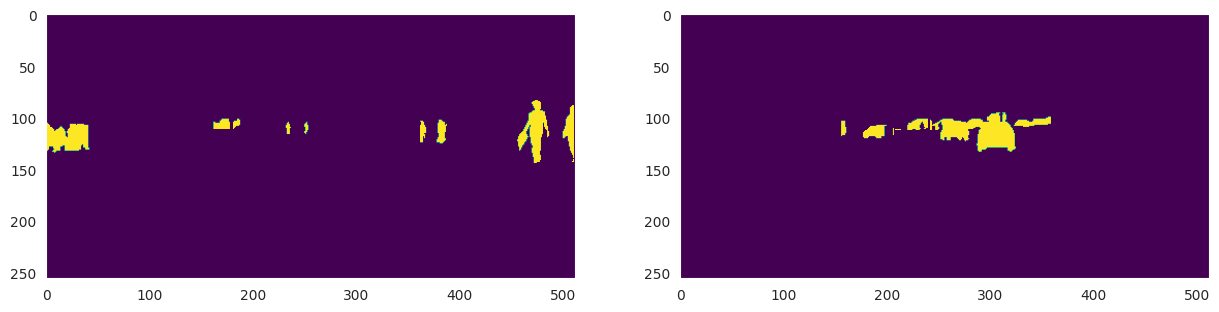

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(np.where(np.array(label)==11, 1, 0), cmap="viridis")
ax[1].imshow(np.where(np.array(label)==13, 1, 0), cmap="viridis")

# UNet Model
## reference: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
## https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948

In [ ]:
def DoubleConv2D(input_dim, output_dim):
    layers = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, 3, 1, 1),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(inplace=True),

        nn.Conv2d(output_dim, output_dim, 3, 1, 1),
        nn.BatchNorm2d(output_dim),
        nn.ReLU(inplace=True)
    )
    return layers

class UNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.conv_block1 = DoubleConv2D(3, 64)
        self.conv_block2 = DoubleConv2D(64, 128)
        self.conv_block3 = DoubleConv2D(128, 256)
        self.conv_block4 = DoubleConv2D(256, 512)
        self.conv_block5 = DoubleConv2D(512, 1024)
        self.pooling = nn.MaxPool2d(2, 2)

        self.deconv1 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.deconv2 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.deconv3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.deconv4 = nn.ConvTranspose2d(128, 64, 2, 2)

        self._conv_block4 = DoubleConv2D(1024, 512)
        self._conv_block3 = DoubleConv2D(512, 256)
        self._conv_block2 = DoubleConv2D(256, 128)
        self._conv_block1 = DoubleConv2D(128, 64)

        self.out = nn.Conv2d(64, output_dim, 1)


    def forward(self, x):
        block1 = self.conv_block1(x)
        block2 = self.conv_block2(self.pooling(block1))
        block3 = self.conv_block3(self.pooling(block2))
        block4 = self.conv_block4(self.pooling(block3))
        block5 = self.conv_block5(self.pooling(block4))

        _block4 = self._conv_block4(torch.concat((block4, self.deconv1(block5)), axis=1))
        _block3 = self._conv_block3(torch.concat((block3, self.deconv2(_block4)), axis=1))
        _block2 = self._conv_block2(torch.concat((block2, self.deconv3(_block3)), axis=1))
        _block1 = self._conv_block1(torch.concat((block1, self.deconv4(_block2)), axis=1))
        return self.out(_block1)

# Configuration

In [ ]:
config = {
         "seed":1314520,
         "img_h":256,
         "img_w":512,
         "batch_size":8,
         "lr":5e-5,
         "epoch":50,
         "earlystopping":5}

if torch.cpu.is_available():
    device = "cuda"
elif torch.backend.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'cuda'

In [ ]:
train_dataset, test_dataset, valid_dataset = CitySpaceDataset(split="train", tsfm=tsfm, label_tsfm=label_tsfm),\
                                             CitySpaceDataset(split="test", tsfm=tsfm, label_tsfm=label_tsfm),\
                                             CitySpaceDataset(split="val", tsfm=tsfm, label_tsfm=label_tsfm)

train_loader, test_loader, valid_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, pin_memory=True),\
                                          DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True, pin_memory=True),\
                                          DataLoader(valid_dataset, batch_size=config["batch_size"], shuffle=True, pin_memory=True)
print(len(train_loader), len(test_loader), len(valid_loader))
x, y = next(iter(train_loader))
print(x.size(), y.size())

372 191 63
torch.Size([8, 3, 256, 512]) torch.Size([8, 1, 256, 512])


In [ ]:
y.unique()

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         15,  17,  18, 255], dtype=torch.uint8)

In [ ]:
model = UNet(output_dim=19).to(device)
x, y = x.to(device), y.to(device)
pred = model(x)
print(pred.size(), y.size())
loss_fn = nn.CrossEntropyLoss(ignore_index=255)
loss = loss_fn(pred.cpu(), y.squeeze(1).cpu().long())
loss

torch.Size([16, 19, 256, 512]) torch.Size([16, 1, 256, 512])


tensor(3.0671, grad_fn=<NllLoss2DBackward0>)

# training

In [ ]:
def trainer(model, device, train_loader, valid_loader, config):
    img_h, img_w = config["img_h"], config["img_w"]
    loss_fn = nn.CrossEntropyLoss(ignore_index=255)
    optim = torch.optim.Adam(model.parameters(), lr=config["lr"])

    min_loss, n_epoch, n_earlystopping = math.inf, config["epoch"], 0

    history = dict(train_loss=[], train_acc=[], valid_loss=[], valid_acc=[])

    for epoch in range(n_epoch):
        # training
        model.train()
        avg_loss = []
        avg_acc = []

        train_pbar = tqdm(train_loader, position=0, leave=True)
        for batch in train_pbar:
            optim.zero_grad()
            X, y = batch
            X, y = X.to(device), y.to(device)
            pred = model(X)

            loss = loss_fn(pred.cpu(), y.cpu().squeeze(1).long())
            loss.backward()
            optim.step()

            acc = (pred.argmax(1).flatten() == y.squeeze(1).flatten()).sum() / (len(y.squeeze(1).flatten()))

            avg_loss.append(loss.detach().item())
            avg_acc.append(acc.detach().item())
            train_pbar.set_description(f"Epoch:{epoch+1}")
            train_pbar.set_postfix({"avg_loss":f"{loss:.2f}", "avg_acc":f"{acc:.2f}"})

        avg_loss = np.mean(avg_loss)
        avg_acc = np.mean(avg_acc)
        history["train_loss"].append(avg_loss)
        history["train_acc"].append(avg_acc)

        # validation
        model.eval()
        avg_loss = []
        avg_acc = []

        valid_pbar = tqdm(valid_loader, position=0, leave=True)
        for batch in valid_pbar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                pred = model(X)
            loss = loss_fn(pred.cpu(), y.cpu().squeeze(1).long())

            acc = (pred.argmax(1).flatten() == y.squeeze(1).flatten()).sum() / (len(y.squeeze(1).flatten()))

            avg_loss.append(loss.detach().item())
            avg_acc.append(acc.detach().item())

            valid_pbar.set_description(f"Epoch:{epoch+1}")
            valid_pbar.set_postfix({"avg_loss":f"{loss:.2f}", "avg_acc":f"{acc:.2f}"})

        avg_loss = np.mean(avg_loss)
        avg_acc = np.mean(avg_acc)
        history["valid_loss"].append(avg_loss)
        history["valid_acc"].append(avg_acc)

        if avg_loss <= min_loss:
            torch.save(model.state_dict(), f"UNet_lr_{str(config['lr'])}_best.pth")
            print(f"Saving the best model with avg_loss: {avg_loss:.2f} and avg_acc: {avg_acc:.2f}")
            min_loss = avg_loss
            n_earlystopping = 0
        else:
            n_earlystopping +=1
            if n_earlystopping >= config["earlystopping"]:
                print(f"Model is not improving for secutive {n_earlystopping} epochs, so we halted the training.")
                break

    return history

same_seed(config["seed"])
model = UNet(output_dim=19).to(device)
history = trainer(model, device, train_loader, valid_loader, config)

Epoch:1: 100%|██████████| 63/63 [15:41<00:00, 14.95s/it, avg_loss=1.22, avg_acc=0.61]


Saving the best model with avg_loss: 1.00 and avg_acc: 0.72


Epoch:2: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.63, avg_acc=0.79]


Saving the best model with avg_loss: 0.76 and avg_acc: 0.74


Epoch:3: 100%|██████████| 63/63 [01:02<00:00,  1.01it/s, avg_loss=0.83, avg_acc=0.71]


Saving the best model with avg_loss: 0.69 and avg_acc: 0.73


Epoch:4: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.70, avg_acc=0.69]


Saving the best model with avg_loss: 0.56 and avg_acc: 0.76


Epoch:5: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.54, avg_acc=0.74]


Saving the best model with avg_loss: 0.53 and avg_acc: 0.76


Epoch:6: 100%|██████████| 63/63 [01:02<00:00,  1.01it/s, avg_loss=0.39, avg_acc=0.74]


Saving the best model with avg_loss: 0.47 and avg_acc: 0.77


Epoch:7: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.50, avg_acc=0.72]


Saving the best model with avg_loss: 0.46 and avg_acc: 0.77


Epoch:8: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.53, avg_acc=0.74]


Saving the best model with avg_loss: 0.43 and avg_acc: 0.77


Epoch:9: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.46, avg_acc=0.75]


Saving the best model with avg_loss: 0.38 and avg_acc: 0.78


Epoch:11: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.28, avg_acc=0.83]


Saving the best model with avg_loss: 0.36 and avg_acc: 0.79


Epoch:12: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.33, avg_acc=0.77]


Saving the best model with avg_loss: 0.36 and avg_acc: 0.79


Epoch:13: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.50, avg_acc=0.72]


Saving the best model with avg_loss: 0.35 and avg_acc: 0.79


Epoch:14: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.39, avg_acc=0.71]


Saving the best model with avg_loss: 0.33 and avg_acc: 0.79


Epoch:17: 100%|██████████| 63/63 [01:03<00:00,  1.00s/it, avg_loss=0.35, avg_acc=0.77]


Saving the best model with avg_loss: 0.32 and avg_acc: 0.79


Epoch:18: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.26, avg_acc=0.81]


Saving the best model with avg_loss: 0.31 and avg_acc: 0.80


Epoch:20: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.39, avg_acc=0.74]


Saving the best model with avg_loss: 0.30 and avg_acc: 0.80


Epoch:24: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.29, avg_acc=0.78]


Saving the best model with avg_loss: 0.29 and avg_acc: 0.80


Epoch:28: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.14, avg_acc=0.86]


Saving the best model with avg_loss: 0.29 and avg_acc: 0.81


Epoch:33: 100%|██████████| 63/63 [01:02<00:00,  1.00it/s, avg_loss=0.36, avg_acc=0.80]

Model is not improving for secutive 5 epochs, so we halted the training.


<Axes: >

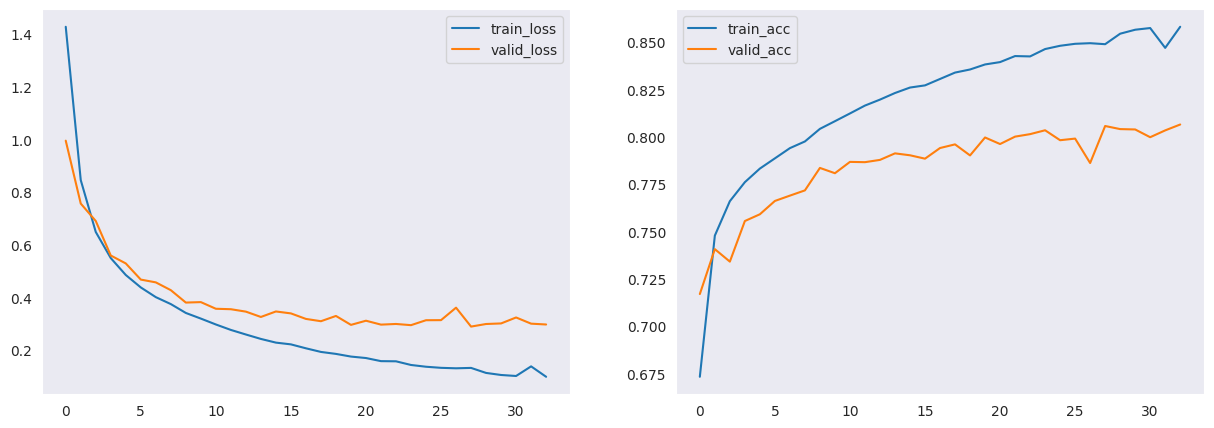

In [ ]:
history_df = pd.DataFrame(history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
history_df[["train_loss", "valid_loss"]].plot(ax=ax[0])
history_df[["train_acc", "valid_acc"]].plot(ax=ax[1])

<Axes: >

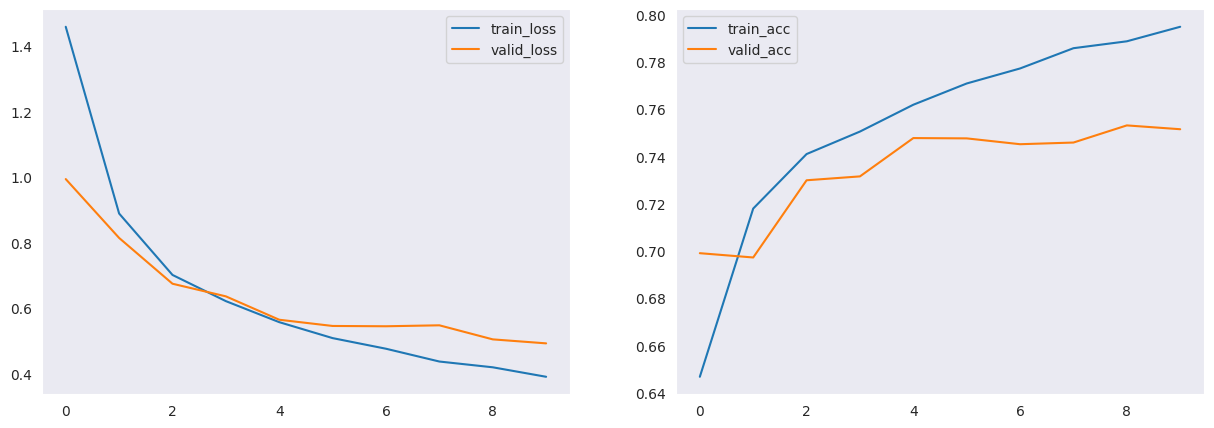

In [ ]:
history_df = pd.DataFrame(history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
history_df[["train_loss", "valid_loss"]].plot(ax=ax[0])
history_df[["train_acc", "valid_acc"]].plot(ax=ax[1])

In [ ]:
print(str(1e-4))

0.0001


In [ ]:
model = UNet(output_dim=19)
model.load_state_dict(torch.load("/content/UNet_best.pth"))
model = model.to(device)

<ipython-input-14-7779df9a3092>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/UNet_best.pth"))


In [ ]:
def inference(model, device, X, y):
    tsfm = transforms.ToPILImage()
    n = X.size()[0]
    X = X.to(device)

    model.eval()
    with torch.no_grad():
        pred = model(X)

    X = X.cpu()
    pred = pred.cpu()
    fig, ax = plt.subplots(n, 3, figsize=(15, 3*n))
    for idx in range(n):
        rgb = tsfm(X[idx])
        gt = np.array(y[idx].squeeze(), dtype=np.uint8)
        gt[gt==255] = 0
        predict = np.array(pred[idx].argmax(0), dtype=np.uint8)
        ax[idx, 0].imshow(rgb)
        ax[idx, 1].imshow(gt, cmap="viridis")
        ax[idx, 2].imshow(predict, cmap="viridis")
    fig.tight_layout()

model = UNet(output_dim=19)
weights_path = "/content/UNet_lr_5e-05best.pth"
model.load_state_dict(torch.load(weights_path))
model = model.to(device)
X, y = next(iter(test_loader))
inference(model, device, X, y)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!scp /content/UNet_lr_5e-05best.pth /content/content/MyDrive/MyAIProjects/.

# Others

In [ ]:
def view():
    root_dir = "/content/content/MyDrive/MyAIProjects"
    rgb_path = os.path.join(root_dir, "./cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png")
    label_path = rgb_path.replace("leftImg8bit.png", "gtFine_labelTrainIds.png").replace("leftImg8bit", "gtFine")
    rgb = cv2.imread(rgb_path)
    label = cv2.imread(label_path, 0)
    fig, ax = plt.subplots(1,2)
    plt.imshow(label)
    ax[0].imshow(rgb)
    ax[1].imshow(label)
view()

In [ ]:
# nn.CorssEntropyLoss
criterion = nn.CrossEntropyLoss(reduction="sum")
pred = torch.randn(3, 5)
target = torch.Tensor([3.0, 4.0, 0.0]).long()
loss = criterion(pred, target)
print(f"loss by function:", loss)

print(f"loss by manual", -(torch.log(pred.softmax(-1)) * nn.functional.one_hot(target)).sum())

loss by function: tensor(7.2539)
loss by manual tensor(7.2539)
